<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4_mb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab One: Visualization and Data Preprocessing

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

## Business Understanding

`Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.`

The data set that our group selected came the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 ([Kaggle](https://www.kaggle.com/usdot/flight-delays)). The data is broken up into three separate `.csv` files: one with flight details for 5,819,079 flights during 2015, one with 14 different U.S.-based airlines, and one with the geographic details of 322 U.S. airports. 

The data is important because it takes airline delays and cancellations, one of the aspects of airline travel that is popular fodder for public complaints, and quantifies it in a way that offers the possiblity of tangible analysis. 

#### TO DO (MATT)

- Describe the two variables to be measured. Arrival delay (regression & RMSE) & Cancellation (classification & accuracy? precision?)
- Measure effectiveness using 10-fold cross-validation


## Data Meaning Type

`Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.`

### Load the Data

In [66]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [67]:
# Due to the way these columns are formatted, we want to keep the leading zeros during our import. Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly from GitHub
airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
# Look at the airline data
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [69]:
# Look at the airport data
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [70]:
# Look at the flight data
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,2354,-11.0,21.0,0015,205,194.0,169.0,1448,0404,4.0,0430,0408,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,0002,-8.0,12.0,0014,280,279.0,263.0,2330,0737,4.0,0750,0741,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,0018,-2.0,16.0,0034,286,293.0,266.0,2296,0800,11.0,0806,0811,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,0015,-5.0,15.0,0030,285,281.0,258.0,2342,0748,8.0,0805,0756,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,0024,-1.0,11.0,0035,235,215.0,199.0,1448,0254,5.0,0320,0259,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#### TO DO (AMBER)

### Merge Flights & Airlines

The flight data will become our primary data set, but we can join it with the airline information to bring in the human-readable names.

In [71]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

In [72]:
# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

In [73]:
# Look at the newly merged data
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,2354,-11.0,21.0,0015,205,194.0,169.0,1448,0404,4.0,0430,0408,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,0002,-8.0,12.0,0014,280,279.0,263.0,2330,0737,4.0,0750,0741,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,0018,-2.0,16.0,0034,286,293.0,266.0,2296,0800,11.0,0806,0811,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,0015,-5.0,15.0,0030,285,281.0,258.0,2342,0748,8.0,0805,0756,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,0024,-1.0,11.0,0035,235,215.0,199.0,1448,0254,5.0,0320,0259,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.


Our merged data set contains 5,819,079 observations and 32 attributes.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819079 entries, 0 to 5819078
Data columns (total 32 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE_CODE         object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  object 
 10  DEPARTURE_TIME       object 
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           object 
 14  SCHEDULED_TIME       object 
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            object 
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    object 
 21  ARRIVAL_TIME         object 
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

### Convert String Columns to Datetime

In [75]:
# Convert string columns to datetime
# Source: https://stackoverflow.com/questions/41514173/change-multiple-columns-in-pandas-dataframe-to-datetime
#df.iloc[:, [9, 10, 13, 18, 20, 21]] = df.iloc[:, [9, 10, 13, 18, 20, 21]].apply(pd.to_datetime, format='%H%M', errors = 'coerce')

In [76]:
cols = ["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   "WHEELS_OFF",  
   "WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]

df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

#df[cols] = df[cols].apply(pd.to_datetime, exact = False, format = '%H%M')
#df[cols] = df[cols].apply(datetime.strptime,format = '%H%M')

In [77]:
df[["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   "WHEELS_OFF", 
   "WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,WHEELS_OFF,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,1900-01-01 00:05:00,1900-01-01 23:54:00,1900-01-01 00:15:00,1900-01-01 04:04:00,1900-01-01 04:30:00,1900-01-01 04:08:00
1,1900-01-01 00:10:00,1900-01-01 00:02:00,1900-01-01 00:14:00,1900-01-01 07:37:00,1900-01-01 07:50:00,1900-01-01 07:41:00
2,1900-01-01 00:20:00,1900-01-01 00:18:00,1900-01-01 00:34:00,1900-01-01 08:00:00,1900-01-01 08:06:00,1900-01-01 08:11:00
3,1900-01-01 00:20:00,1900-01-01 00:15:00,1900-01-01 00:30:00,1900-01-01 07:48:00,1900-01-01 08:05:00,1900-01-01 07:56:00
4,1900-01-01 00:25:00,1900-01-01 00:24:00,1900-01-01 00:35:00,1900-01-01 02:54:00,1900-01-01 03:20:00,1900-01-01 02:59:00


### Convert YEAR, MONTH, DAY into a Single Date

In [78]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

## Data Quality

`Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.`

### Missing Values

In [79]:
# How many missing values are there in the data?
df.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE_CODE                 0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86666
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89774
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                94518
TAXI_IN                  92513
SCHEDULED_ARRIVAL            2
ARRIVAL_TIME             94969
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
AIRLINE                      0
FLIGHT_D

There are millions of missing values in the specific delay time columns. This is expected, as not every flight is delayed, and you would hope that percentage would be small of the overall flights. We will convert these missing values into `0` since, in these cases, there was no flight delay for the specific attribute.

In [80]:
# Replace missing values in AIRLINE_DELAY, AIR_SYSTEM_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, and WEATHER_DELAY with '0'
df[['AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] = df[['AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].fillna(value = 0)

Similar to the delay columns, the `CANCELLATION_REASON` column also contains millions of missing values. Here we convert the missing values to `0` and use one hot encoding on the resulting column.

In [81]:
# One hot encode CANCELLATION_REASON where NA = 0
# Source: datagy.io/pandas-get-dummies/

# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# One hot encode
one_hot_columns = ['CANCELLATION_REASON']

for column in one_hot_columns:
  tempdf = pd.get_dummies(df[column], prefix=column)

  df = pd.merge(
      left = df,
      right = tempdf,
      left_index = True,
      right_index = True,
  )

  df = df.drop(columns=column)

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,FLIGHT_DATE,CANCELLATION_REASON_A,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_D,CANCELLATION_REASON_N
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,1900-01-01 00:05:00,1900-01-01 23:54:00,-11.0,21.0,1900-01-01 00:15:00,205,194.0,169.0,1448,1900-01-01 04:04:00,4.0,1900-01-01 04:30:00,1900-01-01 04:08:00,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,2015-01-01,0,0,0,0,1
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,1900-01-01 00:10:00,1900-01-01 00:02:00,-8.0,12.0,1900-01-01 00:14:00,280,279.0,263.0,2330,1900-01-01 07:37:00,4.0,1900-01-01 07:50:00,1900-01-01 07:41:00,-9.0,0,0,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,0,0,0,0,1
2,2015,1,1,4,US,840,N171US,SFO,CLT,1900-01-01 00:20:00,1900-01-01 00:18:00,-2.0,16.0,1900-01-01 00:34:00,286,293.0,266.0,2296,1900-01-01 08:00:00,11.0,1900-01-01 08:06:00,1900-01-01 08:11:00,5.0,0,0,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,2015-01-01,0,0,0,0,1
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,1900-01-01 00:20:00,1900-01-01 00:15:00,-5.0,15.0,1900-01-01 00:30:00,285,281.0,258.0,2342,1900-01-01 07:48:00,8.0,1900-01-01 08:05:00,1900-01-01 07:56:00,-9.0,0,0,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,0,0,0,0,1
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,1900-01-01 00:25:00,1900-01-01 00:24:00,-1.0,11.0,1900-01-01 00:35:00,235,215.0,199.0,1448,1900-01-01 02:54:00,5.0,1900-01-01 03:20:00,1900-01-01 02:59:00,-21.0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,2015-01-01,0,0,0,0,1


In [82]:
# How many missing values are there in the data now?
df.isnull().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE_CODE                  0
FLIGHT_NUMBER                 0
TAIL_NUMBER               14721
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTURE_TIME            86666
DEPARTURE_DELAY           86153
TAXI_OUT                  89047
WHEELS_OFF                89774
SCHEDULED_TIME                6
ELAPSED_TIME             105071
AIR_TIME                 105071
DISTANCE                      0
WHEELS_ON                 94518
TAXI_IN                   92513
SCHEDULED_ARRIVAL             2
ARRIVAL_TIME              94969
ARRIVAL_DELAY            105071
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
AIRLINE                       0
FLIGHT_D

Here the remaining rows containing missing data only account for about 2% of the total number of original observations. We feel comfortable removing those rows with missing values and proceeding with our analysis.

In [83]:
#check counts of cancels and diversions
df.groupby('CANCELLED')['YEAR'].count()

CANCELLED
0    5729195
1      89884
Name: YEAR, dtype: int64

In [84]:
# Drop the remaining rows that contain missing values
#df = df.dropna(axis=0)

#this line is a problem - as you can see above it drops all the cancelled flights. will need to fix.

MB comment: I updated from here to change to binary & 0's because it dropped the cancels otherwise.

In [85]:
#update missing values in times to 0. will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)
#change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

#change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

df.isna().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE_CODE                  0
FLIGHT_NUMBER                 0
TAIL_NUMBER               14721
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTED                      0
DEPARTURE_DELAY           86153
TAXI_OUT                  89047
WHEELS_OFF                89774
SCHEDULED_TIME                6
ELAPSED_TIME             105071
AIR_TIME                 105071
DISTANCE                      0
WHEELS_ON                 94518
TAXI_IN                   92513
SCHEDULED_ARRIVAL             2
ARRIVAL_TIME              94969
ARRIVAL_DELAY            105071
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
AIRLINE                       0
FLIGHT_D

In [86]:
#update remaining columns using same logic

cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)

df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1

df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

df.isna().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE_CODE                  0
FLIGHT_NUMBER                 0
TAIL_NUMBER               14721
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTED                      0
DEPARTURE_DELAY           86153
TAXI_OUT                  89047
WHEELS_OFF                    0
SCHEDULED_TIME                6
ELAPSED_TIME             105071
AIR_TIME                 105071
DISTANCE                      0
WHEELS_ON                     0
TAXI_IN                   92513
SCHEDULED_ARRIVAL             2
ARRIVED                       0
ARRIVAL_DELAY            105071
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
AIRLINE                       0
FLIGHT_D

In [87]:
#fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)
df.isna().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE_CODE                  0
FLIGHT_NUMBER                 0
TAIL_NUMBER               14721
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTED                      0
DEPARTURE_DELAY           86153
TAXI_OUT                  89047
WHEELS_OFF                    0
SCHEDULED_TIME                6
ELAPSED_TIME             105071
AIR_TIME                 105071
DISTANCE                      0
WHEELS_ON                     0
TAXI_IN                   92513
SCHEDULED_ARRIVAL             2
ARRIVED                       0
ARRIVAL_DELAY            105071
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
AIRLINE                       0
FLIGHT_D

In [88]:
#change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0
df.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE_CODE                 0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTED                     0
DEPARTURE_DELAY              0
TAXI_OUT                     0
WHEELS_OFF                   0
SCHEDULED_TIME               6
ELAPSED_TIME             15187
AIR_TIME                 15187
DISTANCE                     0
WHEELS_ON                    0
TAXI_IN                   2629
SCHEDULED_ARRIVAL            2
ARRIVED                      0
ARRIVAL_DELAY            15187
DIVERTED                     0
CANCELLED                    0
AIR_SYSTEM_DELAY             0
SECURITY_DELAY               0
AIRLINE_DELAY                0
LATE_AIRCRAFT_DELAY          0
WEATHER_DELAY                0
AIRLINE                      0
FLIGHT_DATE                  0
CANCELLA

In [89]:
#remove remaining null value
df = df.dropna()

In [90]:
df.isna().sum()

YEAR                     0
MONTH                    0
DAY                      0
DAY_OF_WEEK              0
AIRLINE_CODE             0
FLIGHT_NUMBER            0
TAIL_NUMBER              0
ORIGIN_AIRPORT           0
DESTINATION_AIRPORT      0
SCHEDULED_DEPARTURE      0
DEPARTED                 0
DEPARTURE_DELAY          0
TAXI_OUT                 0
WHEELS_OFF               0
SCHEDULED_TIME           0
ELAPSED_TIME             0
AIR_TIME                 0
DISTANCE                 0
WHEELS_ON                0
TAXI_IN                  0
SCHEDULED_ARRIVAL        0
ARRIVED                  0
ARRIVAL_DELAY            0
DIVERTED                 0
CANCELLED                0
AIR_SYSTEM_DELAY         0
SECURITY_DELAY           0
AIRLINE_DELAY            0
LATE_AIRCRAFT_DELAY      0
WEATHER_DELAY            0
AIRLINE                  0
FLIGHT_DATE              0
CANCELLATION_REASON_A    0
CANCELLATION_REASON_B    0
CANCELLATION_REASON_C    0
CANCELLATION_REASON_D    0
CANCELLATION_REASON_N    0
d

### Outliers

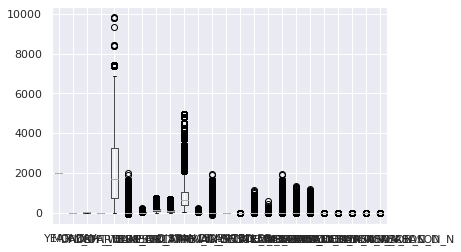

In [91]:
# Check for outliers on continuous variables
# Source: https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
num_col = df.select_dtypes(include = np.number).columns.tolist() 
df.boxplot(column = num_col)

Note... need to do some more work here, group at different scales or split out individually

#### TO DO (BLAKE)

- Address outliers
- Amber work on airport codes
- We need to finish cleaning up the time conversions (someone)

## Simple Statistics

`Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful.`

In [92]:
df.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,CANCELLATION_REASON_A,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_D,CANCELLATION_REASON_N
count,5789165.0,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5789165.0,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06,5.789165e+06
mean,2015.0,6.529244e+00,1.570191e+01,3.928717e+00,2.174812e+03,9.174156e+00,1.585693e+01,1.352275e+02,1.120380e+02,8.216556e+02,7.332616e+00,4.349829e+00,0.0,1.298253e-02,2.476309e+00,1.398906e-02,3.484605e+00,4.311822e+00,5.355233e-01,3.496359e-03,7.000491e-03,2.481878e-03,3.800203e-06,9.870175e-01
std,0.0,3.403785e+00,8.780918e+00,1.988249e+00,1.758028e+03,3.666456e+01,9.010045e+00,7.534131e+01,7.290175e+01,6.073949e+02,5.645347e+00,3.901872e+01,0.0,1.131989e-01,1.308833e+01,9.191515e-01,2.190996e+01,2.062496e+01,8.830108e+00,5.902656e-02,8.337557e-02,4.975659e-02,1.949407e-03,1.131989e-01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00,-8.700000e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.310000e+02,-5.000000e+00,1.100000e+01,8.100000e+01,5.900000e+01,3.720000e+02,4.000000e+00,-1.300000e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.691000e+03,-1.000000e+00,1.400000e+01,1.170000e+02,9.300000e+01,6.470000e+02,6.000000e+00,-5.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.234000e+03,7.000000e+00,1.900000e+01,1.680000e+02,1.430000e+02,1.062000e+03,9.000000e+00,7.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,1.988000e+03,2.250000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.480000e+02,1.971000e+03,0.0,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


As we saw from the outset, the data spans for all months in the year of 2015. Based on the structure of our data, not a lot can be gleaned from the summary statistics and individual variables need additional exploration outside of the overall summary. Let's start by verifying total number of flights within the data set that have been cancelled or diverted.

In [93]:
#check counts of cancels and diversions
df.groupby('CANCELLED')['YEAR'].count()

CANCELLED
0    5714007
1      75158
Name: YEAR, dtype: int64

In [94]:
df.groupby('DIVERTED')['YEAR'].count()

DIVERTED
0    5789165
Name: YEAR, dtype: int64

This method seems to have removed all of the diverted flights. Do we want to keep them?


Next, let's see if there is any useful insights based on the most frequent flight departure and arrival times.

In [95]:
#find median and mode for flight departure times & arrival times

In [96]:
#find if there is a common day of week 

#### TO DO (MEGAN)


## Visualize Attributes

`Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.`

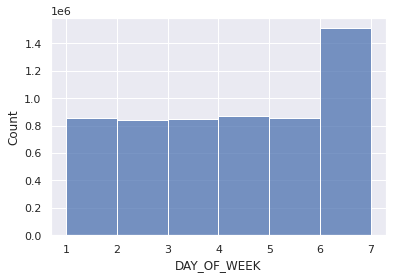

In [97]:
# Flights by day of the week
sns.histplot(df, x = 'DAY_OF_WEEK', binwidth = 1)

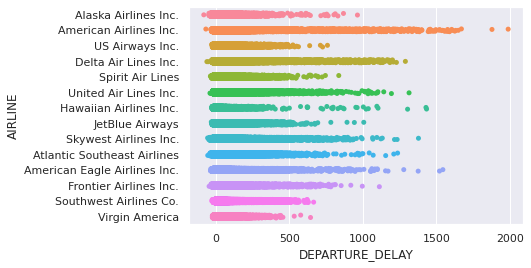

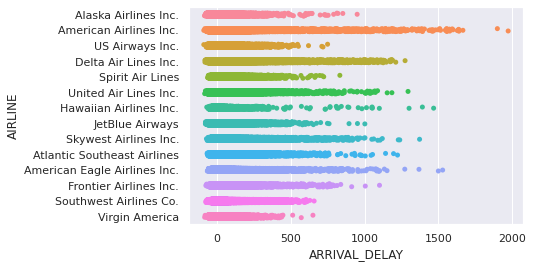

In [98]:
# Delays by airline
sns.stripplot(x='DEPARTURE_DELAY', y='AIRLINE',
              data=df, dodge=True, jitter=True)

plt.show()

sns.stripplot(x='ARRIVAL_DELAY', y='AIRLINE',
              data=df, dodge=True, jitter=True)

plt.show()

American is the clear leader(?) here, but I also imagine they are one of the largest carriers in this list. Do the numbers skew the results here at all?

In [99]:
#most common day of week for flight cancellation

In [100]:
#most common time of day for departure delay

#### TO DO (EVERYONE)

- Create 2+ visualizations per person plus an explanation for each

## Explore Joint Attributes

`Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.`

In [ ]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

sns.heatmap(df.corr(), cmap=cmap, annot = True)

#### TO DO (MEGAN)

In [ ]:
#plot departure delay vs arrival delay

In [ ]:
#plot bar chart for cancellation reason color coded by year/month/day

## Explore Attributes and Class

`Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).`

#### TO DO (AMBER)

## New Features 

`Are there other features that could be added to the data or created from existing features? Which ones?`

#### TO DO (BLAKE)

## Exceptional Work

`You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results. (aka PCA)`

In [ ]:
# Look at what continuous variables we have to work with
df.select_dtypes(np.number).head()

In [ ]:
# Select columns for PCA
df_pca = df[['DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME', 'AIR_TIME', 
            'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY', 'DIVERTED', 
            'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
            'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'CANCELLATION_REASON_A', 
            'CANCELLATION_REASON_B', 'CANCELLATION_REASON_C', 
            'CANCELLATION_REASON_D', 'CANCELLATION_REASON_N']]

In [ ]:
df_pca.shape

In [ ]:
# Source: https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
# Standardize the features
from sklearn.preprocessing import StandardScaler

# Create the object
scaler = StandardScaler()
# Calculate the mean and standard deviation
scaler.fit(df_pca)
df_pca_scaled = scaler.transform(df_pca)

In [ ]:
from sklearn.decomposition import PCA

pca_18 = PCA(n_components=18, random_state=2015)
pca_18.fit(df_pca_scaled)
df_pca_18 = pca_18.transform(df_pca_scaled)

In [ ]:
np.cumsum(pca_18.explained_variance_ratio_*100)

In [ ]:
# Plot PCA results
plt.plot(np.cumsum(pca_18.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [ ]:
print("Variance explained by the first principal component =",
      np.cumsum(pca_18.explained_variance_ratio_*100)[0])
print("Variance explained by the first two principal components =",
      np.cumsum(pca_18.explained_variance_ratio_*100)[1])
print("Variance explained by the first three principal component =",
      np.cumsum(pca_18.explained_variance_ratio_*100)[2])
print("Variance explained by the first six principal components =",
      np.cumsum(pca_18.explained_variance_ratio_*100)[6])
print("Variance explained by the first seven principal components =",
      np.cumsum(pca_18.explained_variance_ratio_*100)[7])

The first six principal components capture 94.17% of the variability in the 18 columns we defined for our PCA data set. Adding a seventh component brings the variability to 99.33%. 

In [ ]:
# PCA 95

pca_95 = PCA(n_components=0.95, random_state=2015)
pca_95.fit(df_pca_scaled)
df_pca_95 = pca_95.transform(df_pca_scaled)

df_pca_95.shape

#### TO DO (MATT)

- PCA on continuous variables
- Map if there is time